In [1]:
## CNN classifier for arming the edge

In [1]:
import tensorflow as tf
import numpy as np

from glob import glob
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Add, Activation, Concatenate, Flatten
from tensorflow.keras.layers import Cropping2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import Sequence
from PIL import Image
import matplotlib.image as mpimg
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Crop white space out of all images if not already done

In [2]:
raw_images = '/lambda_stor/data/rjackson/lidar_pngs/5min/**/*.png'
raw_img_list = glob(raw_images, recursive=True)
print(len(raw_img_list))

19500


In [14]:
for image_file in raw_img_list:
    yourImage = Image.open(image_file)
    yourImage.crop((130, 40, 1320, 410)).save(image_file)

## Augment training images for cloudy by doing a left-right flip, same for rain

In [3]:
cloudy_data_path = '/lambda_stor/data/rjackson/lidar_pngs/5min/training/rain/*.png'
cloud_images = glob(cloudy_data_path)
print(len(cloud_images))

2239


In [4]:
train_datagen_flip = ImageDataGenerator(rescale=1/255., featurewise_std_normalization=True, featurewise_center=True,
                                   samplewise_center=True, horizontal_flip=True)
j = 0
for image in cloud_images:
    img = load_img(image)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape) 
    i = 0
    for batch in train_datagen_flip.flow(x, batch_size=1,
                             save_to_dir='/lambda_stor/data/rjackson/lidar_pngs/5min/training/rain/',
                                         save_prefix='rain_flip', save_format='png'):
        i += 1
        if i > 1:
            break  # otherwise the generator would loop indefinitely
    j += 1
    if j % 100 == 0:
        print('%d/%d' % (len(cloud_images), j))

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


2239/100
2239/200
2239/300
2239/400
2239/500
2239/600
2239/700
2239/800
2239/900
2239/1000
2239/1100
2239/1200
2239/1300
2239/1400
2239/1500
2239/1600
2239/1700
2239/1800
2239/1900
2239/2000
2239/2100
2239/2200


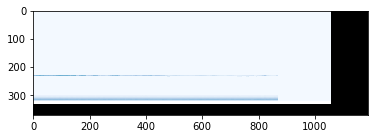

In [17]:
img=mpimg.imread('/lambda_stor/data/rjackson/lidar_pngs/5min/training/cloud/cloud_flip_0_3804.png')
imgplot = plt.imshow(img)
plt.show()
# (150, 50), (1300, 400)

In [2]:
train_datagen = ImageDataGenerator(rescale=1/255., featurewise_std_normalization=True, featurewise_center=True,
                                   samplewise_std_normalization=True,
                                   samplewise_center=True)
train_datagen_flip = ImageDataGenerator(samplewise_std_normalization=True, 
                                   samplewise_center=True, horizontal_flip=True)

In [3]:
train_generator = train_datagen.flow_from_directory(directory='/lambda_stor/data/rjackson/lidar_pngs/5min/training',
                                                    class_mode='categorical', classes=['clear', 'cloud', 'rain'],
                                                    target_size=(256, 128), shuffle=True, batch_size=16)
valid_generator = train_datagen.flow_from_directory(directory='/lambda_stor/data/rjackson/lidar_pngs/5min/validation',
                                                    class_mode='categorical', classes=['clear', 'cloud', 'rain'],
                                                    target_size=(256, 128), shuffle=True, batch_size=16)
train_generator_flip = train_datagen_flip.flow_from_directory(directory='/lambda_stor/data/rjackson/lidar_pngs/5min/training',
                                                    class_mode='categorical', classes=['clear', 'cloud', 'rain'],
                                                    target_size=(256, 128))
valid_generator_flip = train_datagen_flip.flow_from_directory(directory='/lambda_stor/data/rjackson/lidar_pngs/5min/validation',
                                                    class_mode='categorical', classes=['clear', 'cloud', 'rain'],
                                                    target_size=(256, 128))

Found 19764 images belonging to 3 classes.
Found 2841 images belonging to 3 classes.
Found 19764 images belonging to 3 classes.
Found 2841 images belonging to 3 classes.


In [4]:
def conv_net_layer(inp, skip=False, num_channels=2, batch_norm=True,
                   activate=True):
    x = Conv2D(num_channels, kernel_size=(3, 3), kernel_initializer='he_normal')(inp)
    if batch_norm:
        x = Dropout(0.2)(x)
    if activate:
        x = Activation('relu')(x)
        x = MaxPooling2D((2, 2))(x)
    return x

def conv_net_layer_up(inp, skip=False, num_channels=2, batch_norm=True,
                   activate=True):
    x = Conv2D(num_channels, kernel_size=(3, 3), kernel_initializer='he_normal')(inp)
    if batch_norm:
        x = Dropout(0.2)(x)
    if activate:
        x = Activation('relu')(x)
        x = UpSampling2D((2, 2))(x)
    return x

def conv_net_classifier(velocity=False):
    ref_inp = Input(shape=(256, 128, 3), name='snr')
      
    layer2 = conv_net_layer(ref_inp, num_channels=32, batch_norm=True,
             activate=True)
    
    layer2 = conv_net_layer(layer2, num_channels=64, batch_norm=True,
             activate=True)
    
    ref_out = conv_net_layer(layer2, num_channels=32, batch_norm=True,
             activate=True)
    ref_out = conv_net_layer(layer2, num_channels=1)

    #ref_out = conv_net_layer(layer2, num_channels=1, batch_norm=True, activate=False)
    #ref_skip = conv_net_layer(ref, num_channels=1, batch_norm=True, activate=False)
    #ref_skip = Activation('relu')(ref_skip)
    #ref_out = Add()([ref_out, ref_skip])
    #ref_out = Activation('relu')(ref_out)
    if velocity:   
        x = Concatenate()([ref_out, vel_out])
    else:
        x = ref_out 
    
    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = Flatten()(x)
    #x = AveragePooling2D()(x)
    outputs = Dense(128, activation='relu')(x)
    outputs = Dense(3, name='targets',
                    activation='softmax',
                    kernel_initializer='he_normal')(outputs)

    #x = Dense(2, activation='relu')(x)
    #x = Dense(3, activation='softmax', name='label')(x)
    if velocity:
        return Model(inputs=[ref_in, vel_in], outputs=outputs)
    else:
        return Model(ref_inp, outputs)

In [5]:
model = conv_net_classifier()
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
snr (InputLayer)             [(None, 256, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 126, 32)      896       
_________________________________________________________________
dropout (Dropout)            (None, 254, 126, 32)      0         
_________________________________________________________________
activation (Activation)      (None, 254, 126, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 63, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 61, 64)       18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 61, 64)      

In [6]:
checkpointer = ModelCheckpoint(
            filepath=('/homes/rjackson/arming_the_edge/models/classifier-%dframes-{epoch:03d}.hdf5'),
            verbose=1)
model.fit(train_generator, validation_data=valid_generator, epochs=150, callbacks=[checkpointer], initial_epoch=0)

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/150


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node functional_1/conv2d/Conv2D (defined at <ipython-input-6-db824821ee93>:4) ]] [Op:__inference_train_function_1094]

Function call stack:
train_function


In [8]:
labels_predict = model.predict(valid_generator)

In [15]:
classes = np.argmax(labels_predict, axis=1)

In [50]:
train_generator[0]

(array([[[[0.01083761, 0.01083761, 0.01083761],
          [0.01083761, 0.01083761, 0.01083761],
          [0.01083761, 0.01083761, 0.01083761],
          ...,
          [0.01083761, 0.01083761, 0.01083761],
          [0.01083761, 0.01083761, 0.01083761],
          [0.01083761, 0.01083761, 0.01083761]],
 
         [[0.01083761, 0.01083761, 0.01083761],
          [0.01083761, 0.01083761, 0.01083761],
          [0.01083761, 0.01083761, 0.01083761],
          ...,
          [0.01083761, 0.01083761, 0.01083761],
          [0.01083761, 0.01083761, 0.01083761],
          [0.01083761, 0.01083761, 0.01083761]],
 
         [[0.01083761, 0.01083761, 0.01083761],
          [0.01083761, 0.01083761, 0.01083761],
          [0.01083761, 0.01083761, 0.01083761],
          ...,
          [0.01083761, 0.01083761, 0.01083761],
          [0.01083761, 0.01083761, 0.01083761],
          [0.01083761, 0.01083761, 0.01083761]],
 
         ...,
 
         [[0.01083761, 0.01083761, 0.01083761],
          [0.01083

In [53]:
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()


In [11]:
train_generator = train_datagen.flow_from_directory(directory='/lambda_stor/data/rjackson/lidar_pngs/5min/training',
                                                    class_mode='input', target_size=(254, 126), shuffle=True,
                                                    batch_size=16)
valid_generator = train_datagen.flow_from_directory(directory='/lambda_stor/data/rjackson/lidar_pngs/5min/validation',
                                                    class_mode='input', 
                                                    target_size=(254, 126), shuffle=True, batch_size=16)

Found 19764 images belonging to 3 classes.
Found 2841 images belonging to 3 classes.


In [21]:
def conv_net_encoder():
    ref_inp = Input(shape=(254, 126, 3), name='snr')
      
    x = Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu')(ref_inp)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu')(ref_inp)
    x = MaxPooling2D((2,2))(x)
    ref_out = Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu')(x)
    ref_out = MaxPooling2D((2,2))(ref_out)
    ref_out = Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu')(ref_out)
    ref_out = MaxPooling2D((2,2))(ref_out)
    
    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = Flatten()(ref_out)
    #x = AveragePooling2D()(x)
    outputs = Dense(10, activation='relu')(x)
    
    dense_1 = Dense(30*14*32, activation='relu')(outputs)
    dense_1 = Reshape((30,14,32))(dense_1)
    inp = UpSampling2D((2,2))(dense_1)
    x = Conv2DTranspose(32, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu')(inp)
    x = UpSampling2D((2,2))(dense_1)
    ref_out = Conv2DTranspose(32, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu')(x)
    ref_out = UpSampling2D((2,2))(ref_out)
    ref_out = Conv2DTranspose(32, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu')(x)
    ref_out = UpSampling2D((2,2))(ref_out)
    ref_out = Conv2DTranspose(32, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu')(ref_out)
    ref_out = UpSampling2D((2,2))(ref_out)
    ref_out = Conv2DTranspose(3, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu')(ref_out)    
    return Model(ref_inp, ref_out)

In [22]:
autoencoder = conv_net_encoder()

In [23]:
autoencoder.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
autoencoder.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
snr (InputLayer)             [(None, 254, 126, 3)]     0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 252, 124, 32)      896       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 126, 62, 32)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 124, 60, 32)       9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 62, 30, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 60, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 30, 14, 32)      

In [32]:
array_list = []
for x in train_generator:
    if array_list == []:
        array_list = x
    else:
        array_list = np.concatenate([array_list, x])

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: 

In [ ]:
array_list = []
for x in train_generator:
    if array_list == []:
        array_list = x
    else:
        array_list = np.concatenate([array_list, x])

In [26]:
with tf.device('/device:GPU:2'):
    checkpointer = ModelCheckpoint(
                  filepath=('/homes/rjackson/arming_the_edge/models/encoder-%dframes-{epoch:03d}.hdf5'),
                  verbose=1)
    autoencoder.fit(train_generator, validation_data=valid_generator, epochs=150, callbacks=[checkpointer], initial_epoch=0)

Epoch 1/150


UnknownError: 3 root error(s) found.
  (0) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node functional_11/conv2d_23/Relu (defined at <ipython-input-24-837b435f56f6>:5) ]]
	 [[GroupCrossDeviceControlEdges_0/Adam/Adam/Const/_113]]
  (1) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node functional_11/conv2d_23/Relu (defined at <ipython-input-24-837b435f56f6>:5) ]]
	 [[gradient_tape/functional_11/conv2d_transpose_23/conv2d_transpose/Conv2DBackpropFilter/_90]]
  (2) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node functional_11/conv2d_23/Relu (defined at <ipython-input-24-837b435f56f6>:5) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_4392]

Function call stack:
train_function -> train_function -> train_function


In [29]:
for x in train_generator:
    print(x.shape)

(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)
(16, 254, 126, 3)


KeyboardInterrupt: 